Populating the interactive namespace from numpy and matplotlib


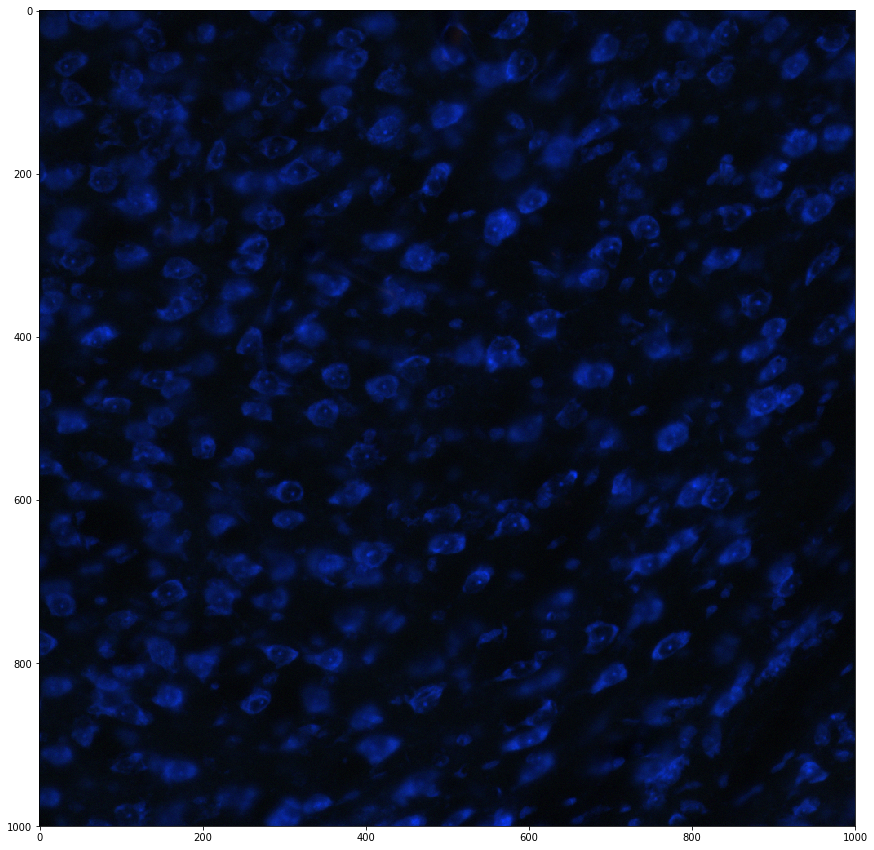

In [1]:
import cv2

import pickle
window=pickle.load(open('../data/window.pkl','rb'))
window.shape

%pylab inline

def normalize(window,range=[0,1],dtype=np.float32):
    _max=max(window.flatten())
    _min=min(window.flatten())
    return np.array((window-_min)/(_max-_min),dtype=dtype)


figure(figsize=[15,15])
imshow(normalize(window));

### checking whether 3 colors carry more information than one.

According to their histograms, they are very different

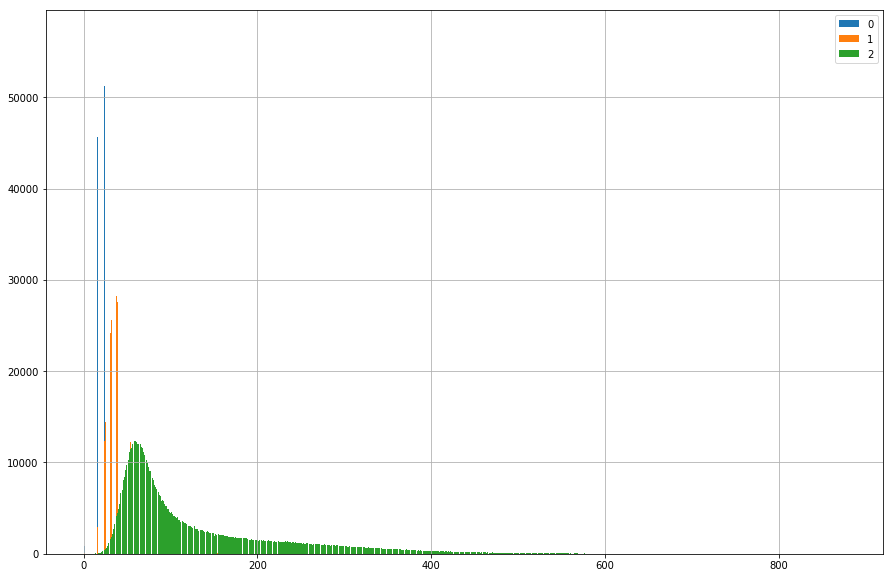

In [2]:
figure(figsize=[15,10])
for i in range(3):
    _flat=window[:,:,i].flatten()
    hist(_flat,bins=1000,label=str(i));
    #xlim([0,0.2])
    #ylim([0,50000])
legend()
grid()

Text(0.5,1,'taking the mean of the 3 colors')

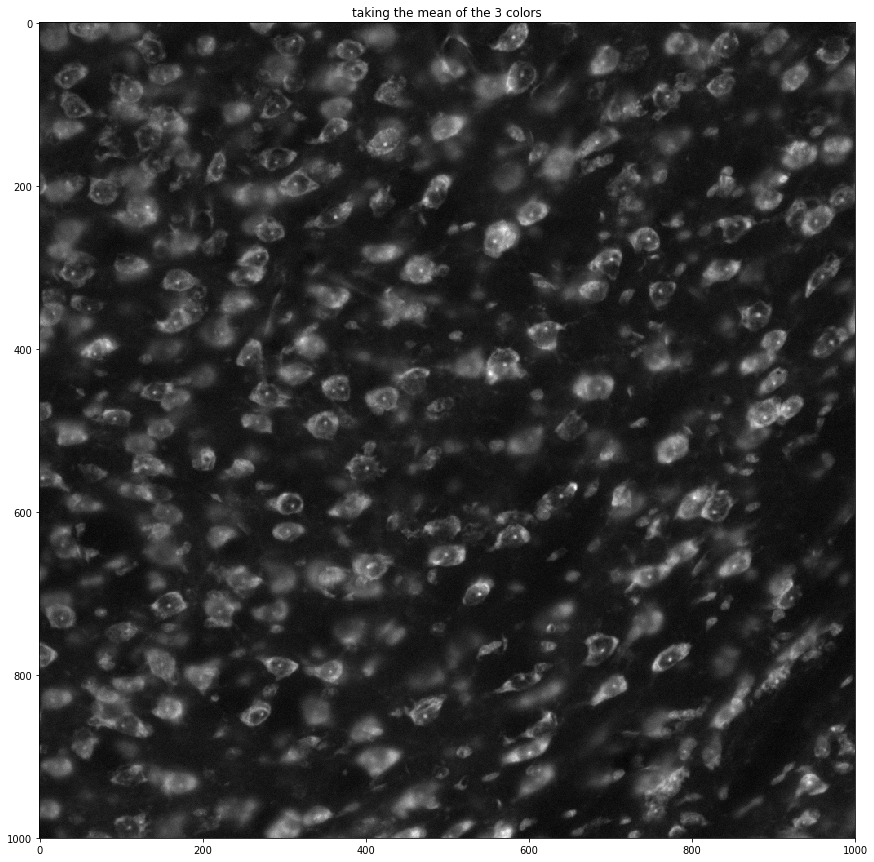

In [3]:
figure(figsize=[15,15])
_mean=normalize(np.mean(window,axis=2))
imshow(_mean,cmap='gray');
title('taking the mean of the 3 colors')

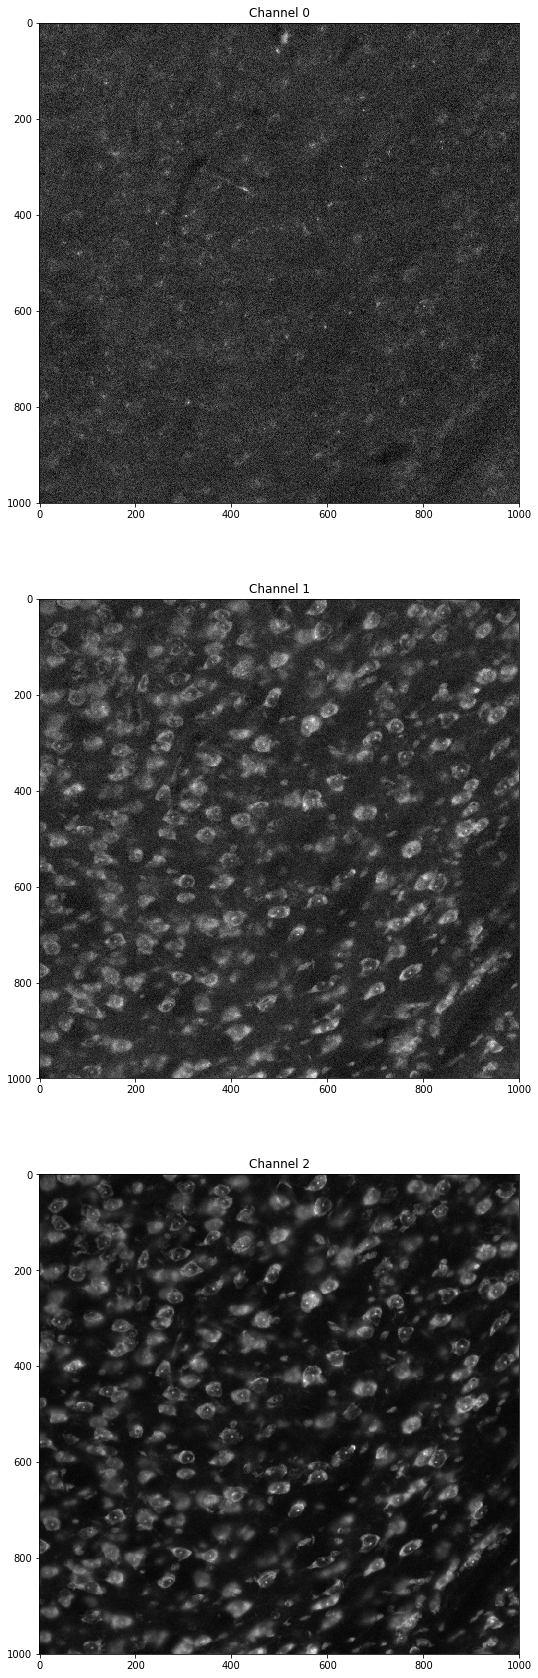

In [4]:
figure(figsize=[10,30])
for i in range(3):
    subplot(3,1,i+1)
    imshow(normalize(window[:,:,i]),cmap='gray')
    title('Channel %d'%i)

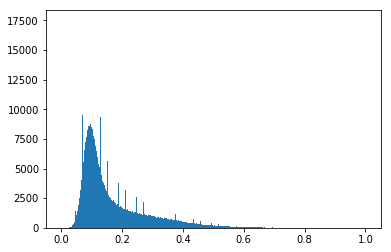

In [5]:
hist(_mean.flatten(),bins=1000);

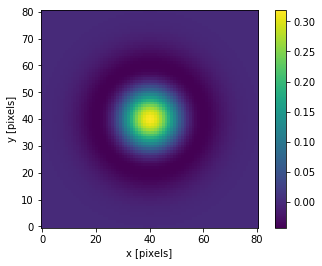

In [6]:
from astropy.convolution import MexicanHat2DKernel
mexicanhat_2D_kernel = 10000*MexicanHat2DKernel(10)
plt.imshow(mexicanhat_2D_kernel, interpolation='none', origin='lower')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

In [7]:
from astropy.convolution import convolve

In [8]:
type(mexicanhat_2D_kernel)

astropy.convolution.kernels.MexicanHat2DKernel

In [9]:
P=convolve(_mean,mexicanhat_2D_kernel)

In [ ]:
figure(figsize=[15,15])
imshow(P[500:550,540:600])

In [ ]:
from photutils.detection import find_peaks

In [ ]:
#find_peaks?

In [ ]:
hist(P.flatten(),bins=100);

In [ ]:
cell_size=41
center=(cell_size-1)/2.
footprint=np.ones([cell_size,cell_size])>1

for i in range(cell_size):
    for j in range(cell_size):
        footprint[i,j]=((i-center)**2+(j-center)**2)<=center**2
imshow(footprint)

In [ ]:
hist(_mean.flatten(),bins=1000);
xlim([0,0.6])
ylim([0,10000])

In [ ]:
Peaks=find_peaks(P,0.4,footprint=footprint)
len(Peaks)

In [ ]:
window.shape

In [ ]:
type(_mean[0,0])

In [ ]:
markers=_mean*np.float32(0)
stamp=np.zeros([cell_size,cell_size],dtype=np.float32)
stamp[:,:]=footprint*np.float32(0.2)
imshow(stamp);

In [ ]:
ratio=1257./(41.*41)
def normalize_greyvals(ex):
    _m=np.mean(ex)/ratio
    _m2=np.mean(ex**2)/ratio
    _std=np.sqrt(_m2-_m**2)
    #print('normalize_greyvals: mean=',_m,'std=',_std)
    ex_new=(ex-_m)/_std
    return ex_new * footprint*1.

In [ ]:
from cv2 import moments,HuMoments

In [ ]:
def angle(ex):
    rows,cols = ex.shape
    M=moments(ex)
    x=M['m10']/M['m00']
    y=M['m01']/M['m00']
    nu20=(M['m20']/M['m00'])-x**2
    nu02=(M['m02']/M['m00'])-y**2
    nu11=(M['m11']/M['m00'])-y*x
    ang_est=-np.arctan(2*nu11/(nu20-nu02))/np.pi+0.5

    if ang_est>0.5:
        ang_est-=1
    ang180=(ang_est+(np.sign(nu11))/2)*90

    if ang180>=180:
        ang180-=360
    if ang180<-180:
        ang180+=360
    return ang180

In [ ]:
def flipOrNot(ex):
    rows,cols = ex.shape
    M=moments(ex)
    x=M['m10']/M['m00'] - cols/2.
    y=M['m01']/M['m00'] - rows/2.
    if abs(x)>abs(y):
        return x<0
    else:
        return y<0


In [ ]:
def normalize_angle(ex):
    rows,cols = ex.shape
    ang=angle(ex)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-ang,1)
    dst= cv2.warpAffine(ex,M,(cols,rows))*footprint*1
    if flipOrNot(dst):
        M180 = cv2.getRotationMatrix2D((cols/2,rows/2),180,1)
        dst = cv2.warpAffine(dst,M180,(cols,rows))

    return ang,dst*footprint*1.

In [ ]:
X=list(Peaks["x_peak"])
Y=list(Peaks["y_peak"])

P_marked=copy(P)
w_marked=copy(window)

extracted=[]
mask=1.*footprint
for i in range(len(X)):
    P_marked[Y[i]-3:Y[i]+3,X[i]-3:X[i]+3]=-20000
    corner_x=np.uint16(X[i]-center)
    corner_y=np.uint16(Y[i]-center)
    if(corner_x<0 or corner_y<0 or \
       corner_x+cell_size>markers.shape[1] or corner_y+cell_size>markers.shape[0]):
        continue
    markers[corner_y:corner_y+cell_size,corner_x:corner_x+cell_size]=stamp
    ex=np.array(_mean[corner_y:corner_y+cell_size,corner_x:corner_x+cell_size])
    ex *= mask
    
    ex_grey_normed=normalize_greyvals(ex)*mask
    rot_angle,ex_rotation_normed=normalize_angle(ex_grey_normed)
    rot_angle,ex_rotation_normed=normalize_angle(ex_rotation_normed)
    extracted.append(ex_rotation_normed*mask)
    

In [ ]:
figure(figsize=[15,15])
imshow(markers+_mean,cmap='gray')

In [ ]:
len(extracted)

In [ ]:
figure(figsize=(15,36))
for i in range(316):
    subplot(32,12,i+1);
    fig=imshow(extracted[i],cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [ ]:
ex=extracted[111]
rows,cols = ex.shape
_diff=[]
_sign=[]
_log=[]
for ang in range(360):
    M = cv2.getRotationMatrix2D((cols/2,rows/2),ang,1)
    dst = cv2.warpAffine(ex,M,(cols,rows))
    diff = angle(dst)
    _diff.append(diff)
    _sign.append(s)
    #print(diff)
plot(_diff);
grid()
#xlim([10,360])
#ylim()
plot(100.*np.array(_log))

In [ ]:

ang=angle(ex)
rotate=0
M1 = cv2.getRotationMatrix2D((cols/2,rows/2),rotate,1)
dst= cv2.warpAffine(ex,M1,(cols,rows))
correction=angle(dst)-ang
M2 = cv2.getRotationMatrix2D((cols/2,rows/2),-correction,1)
restored = cv2.warpAffine(dst,M2,(cols,rows))
if flipOrNot(restored):
    M180 = cv2.getRotationMatrix2D((cols/2,rows/2),180,1)
    restored = cv2.warpAffine(restored,M180,(cols,rows))
res_angle=angle(restored)

print(ang,correction,res_angle)

figure(figsize=[10,4])
subplot(1,3,1)
imshow(ex,cmap='gray')
subplot(1,3,2)
imshow(dst,cmap='gray')
subplot(1,3,3)
imshow(restored,cmap='gray')

In [ ]:
ex=extracted[72]
rotate=30
M1 = cv2.getRotationMatrix2D((cols/2,rows/2),rotate,1)
rotated= cv2.warpAffine(ex,M1,(cols,rows))

ang,dst=normalize_angle(rotated)
corrected=angle(dst)
ang2,dst2=normalize_angle(dst)
corrected2=angle(dst2)

print(rotate,ang,corrected,ang2,corrected2)
figure(figsize=[10,4])
subplot(1,4,1)
imshow(ex,cmap='gray')
subplot(1,4,2)
imshow(rotated,cmap='gray')
subplot(1,4,3)
imshow(dst,cmap='gray')
subplot(1,4,4)
imshow(dst2,cmap='gray')

In [ ]:

hist(ex.flatten(),bins=100);

In [ ]:
hist(dst2.flatten(),bins=100);